# Deep Convolutional Generative Adverserial Network

Reference: https://github.com/AKASHKADEL/dcgan-celeba

# Network Definitions

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# Generator
class Generator(nn.Module):
    def __init__(self, nc, nz, ngf):
        super().__init__()

        # Input is the latent vector Z.
        self.tconv1 = nn.ConvTranspose2d(nz, ngf*8, kernel_size=4, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(ngf*8)

        # Input Dimension: (ngf*8) x 4 x 4
        self.tconv2 = nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(ngf*4)

        # Input Dimension: (ngf*4) x 8 x 8
        self.tconv3 = nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(ngf*2)

        # Input Dimension: (ngf*2) x 16 x 16
        self.tconv4 = nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(ngf)

        # Input Dimension: (ngf) * 32 * 32
        self.tconv5 = nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False)
        #Output Dimension: (nc) x 64 x 64

    def forward(self, x):
        x = F.relu(self.bn1(self.tconv1(x)))
        x = F.relu(self.bn2(self.tconv2(x)))
        x = F.relu(self.bn3(self.tconv3(x)))
        x = F.relu(self.bn4(self.tconv4(x)))

        x = torch.tanh(self.tconv5(x))

        return x
    
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.cv1 = nn.Conv2d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False) # (3, 64, 64) -> (64, 32, 32)
        self.cv2 = nn.Conv2d(ndf, ndf*2, 4, 2, 1 ) # (64, 32, 32) -> (128, 16, 16)
        self.bn2 = nn.BatchNorm2d(ndf*2) # spatial batch norm is applied on num of channels
        self.cv3 = nn.Conv2d(ndf*2, ndf*4, 4, 2, 1) # (128, 16, 16) -> (256, 8, 8)
        self.bn3 = nn.BatchNorm2d(ndf*4)
        self.cv4 = nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False) # (256, 8, 8) -> (512, 4, 4)
        self.bn4 = nn.BatchNorm2d(ndf* 8)
        self.cv5 = nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False) # (512, 4, 4) -> (1, 1, 1)

    def forward(self, x):
        x = F.leaky_relu(self.cv1(x))
        x = F.leaky_relu(self.bn2(self.cv2(x)), 0.2, True)
        x = F.leaky_relu(self.bn3(self.cv3(x)), 0.2, True)
        x = F.leaky_relu(self.bn4(self.cv4(x)), 0.2, True)
        x = torch.sigmoid(self.cv5(x))
        return x.view(-1, 1).squeeze(1)
    
# Weight Initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

# Utility Functions

In [3]:
!pip install natsort

In [4]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import math
import itertools
import imageio
import natsort
from glob import glob

In [5]:
# Function to get the data loader
def get_data_loader(root, batch_size):
    
    transform = transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    dataset = datasets.ImageFolder(root=root, transform=transform)

    # Data Loader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

# Function to generate image plots
def generate_images(epoch, path, fixed_noise, num_test_samples, netG, device, use_fixed=False):
    z = torch.randn(num_test_samples, 100, 1, 1, device=device)
    size_figure_grid = int(math.sqrt(num_test_samples))
    title = None
  
    if use_fixed:
        generated_fake_images = netG(fixed_noise)
        path += 'fixed_noise/'
        title = 'Fixed Noise'
    else:
        generated_fake_images = netG(z)
        path += 'variable_noise/'
        title = 'Variable Noise'
  
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6,6))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i,j].get_xaxis().set_visible(False)
        ax[i,j].get_yaxis().set_visible(False)
    for k in range(num_test_samples):
        i = k//4
        j = k%4
        ax[i,j].cla()
        ax[i,j].imshow((generated_fake_images[k].cpu().data.numpy().transpose(1, 2, 0) + 1) / 2 )
    label = 'Epoch_{}'.format(epoch+1)
    fig.text(0.5, 0.04, label, ha='center')
    fig.suptitle(title)
    fig.savefig(path+label+'.png')
   
# Function to create a gif of image plots
def save_gif(path, fps, max_num=100, fixed_noise=False):
    if fixed_noise==True:
        path += 'fixed_noise/'
    else:
        path += 'variable_noise/'
    images = glob(path + '*.png')
    images = natsort.natsorted(images)
    images = images[:max_num]
    gif = []

    for image in images:
        gif.append(imageio.imread(image))
    imageio.mimsave(path+'animated.gif', gif, fps=fps)

# Training

In [6]:
import argparse
import logging
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
from torchvision.utils import save_image

In [7]:
from easydict import EasyDict as edict

args = {
    'num_epochs': 40,
    'ndf': 64,
    'ngf': 64,
    'nz': 100,
    'd_lr': 0.0002,
    'g_lr': 0.0002,
    'nc': 3,
    'batch_size': 128,
    'num_test_samples': 16,
    'output_path': 'results/',
    'fps': 5,
    'use_fixed': True
}

opt = edict(args)

In [8]:
!mkdir -p results/fixed_noise

Dataset loaded from ../input/celeba-dataset/img_align_celeba/
Using cuda
Epoch [1/40], step [100/1583], d_loss: 0.0046, g_loss: 9.5981, D(x): 1.00, Discriminator - D(G(x)): 0.00, Generator - D(G(x)): 0.00
Epoch [1/40], step [200/1583], d_loss: 0.0038, g_loss: 11.7246, D(x): 1.00, Discriminator - D(G(x)): 0.00, Generator - D(G(x)): 0.00
Epoch [1/40], step [300/1583], d_loss: 0.1084, g_loss: 8.4227, D(x): 0.96, Discriminator - D(G(x)): 0.02, Generator - D(G(x)): 0.00
Epoch [1/40], step [400/1583], d_loss: 0.0186, g_loss: 7.1056, D(x): 0.99, Discriminator - D(G(x)): 0.01, Generator - D(G(x)): 0.00
Epoch [1/40], step [500/1583], d_loss: 0.0108, g_loss: 8.5844, D(x): 1.00, Discriminator - D(G(x)): 0.01, Generator - D(G(x)): 0.00
Epoch [1/40], step [600/1583], d_loss: 0.0046, g_loss: 8.1821, D(x): 1.00, Discriminator - D(G(x)): 0.00, Generator - D(G(x)): 0.00
Epoch [1/40], step [700/1583], d_loss: 0.0183, g_loss: 9.0905, D(x): 0.99, Discriminator - D(G(x)): 0.01, Generator - D(G(x)): 0.00
Ep

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Epoch [22/40], step [100/1583], d_loss: 0.0747, g_loss: 10.1168, D(x): 0.94, Discriminator - D(G(x)): 0.00, Generator - D(G(x)): 0.00
Epoch [22/40], step [200/1583], d_loss: 0.5419, g_loss: 9.9795, D(x): 0.69, Discriminator - D(G(x)): 0.00, Generator - D(G(x)): 0.00
Epoch [22/40], step [300/1583], d_loss: 0.0744, g_loss: 6.4395, D(x): 0.97, Discriminator - D(G(x)): 0.03, Generator - D(G(x)): 0.01
Epoch [22/40], step [400/1583], d_loss: 0.0444, g_loss: 6.9470, D(x): 0.97, Discriminator - D(G(x)): 0.01, Generator - D(G(x)): 0.01
Epoch [22/40], step [500/1583], d_loss: 0.0575, g_loss: 6.6824, D(x): 0.97, Discriminator - D(G(x)): 0.02, Generator - D(G(x)): 0.01
Epoch [22/40], step [600/1583], d_loss: 0.1757, g_loss: 6.5454, D(x): 0.89, Discriminator - D(G(x)): 0.03, Generator - D(G(x)): 0.01
Epoch [22/40], step [700/1583], d_loss: 0.3913, g_loss: 5.1068, D(x): 0.98, Discriminator - D(G(x)): 0.21, Generator - D(G(x)): 0.04
Epoch [22/40], step [800/1583], d_loss: 0.1402, g_loss: 4.1427, D(x)

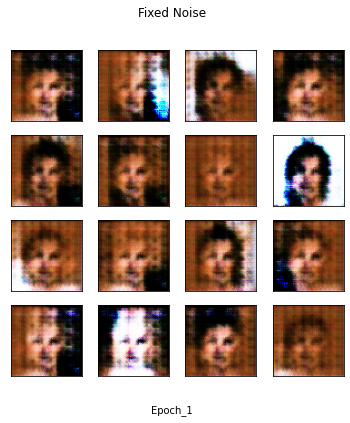

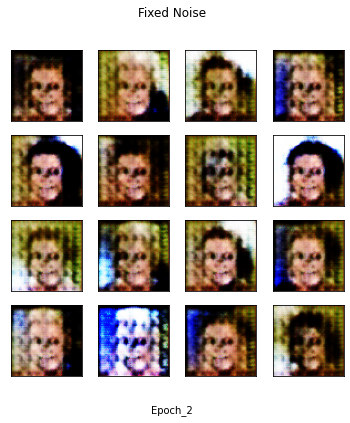

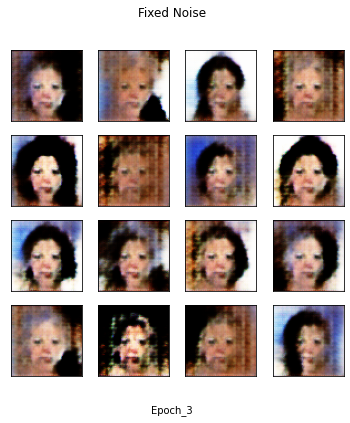

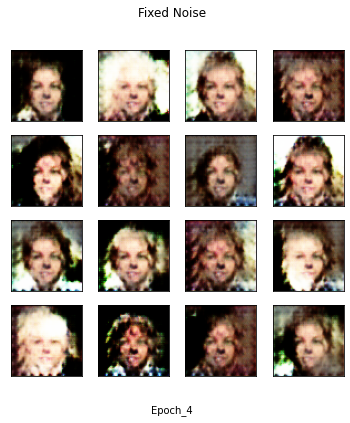

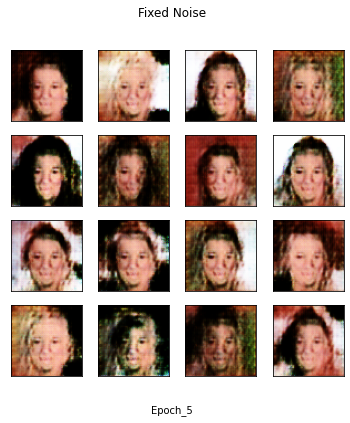

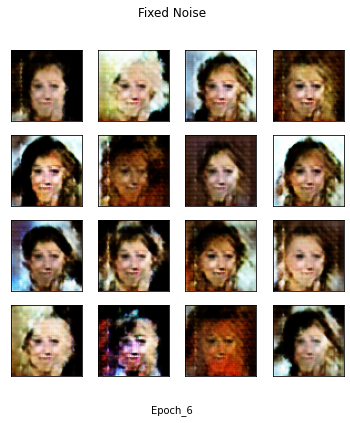

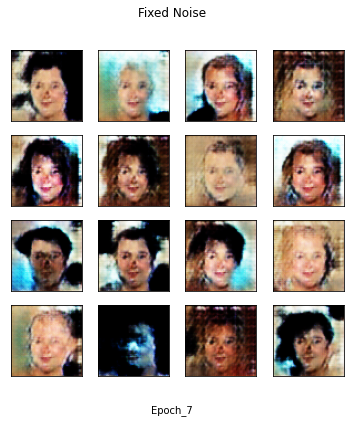

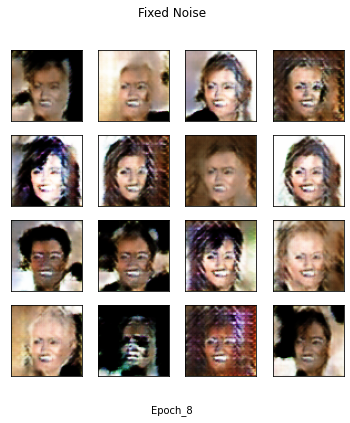

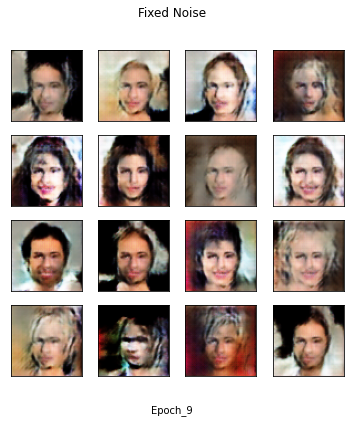

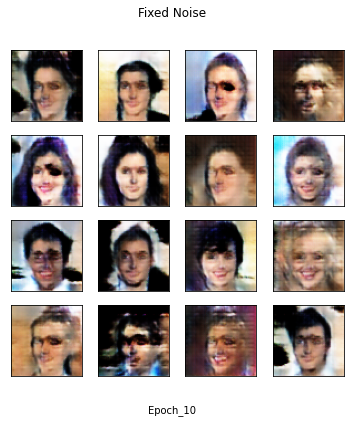

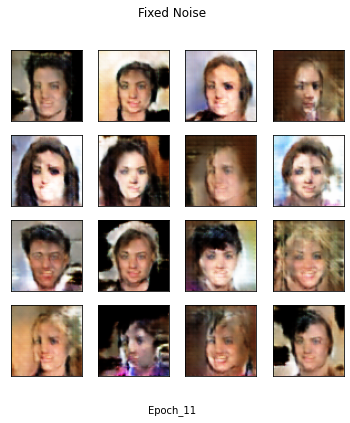

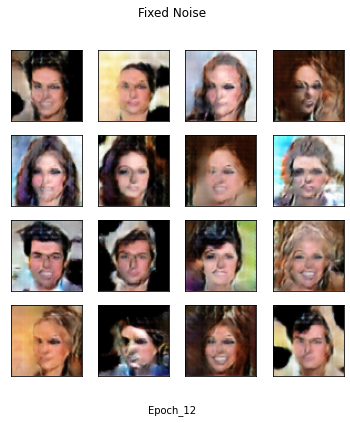

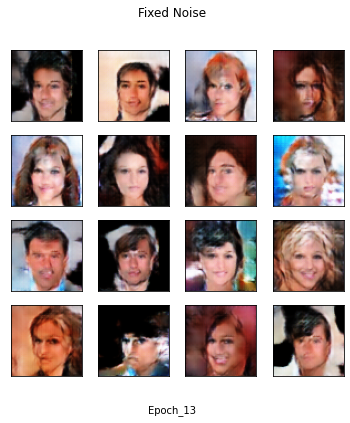

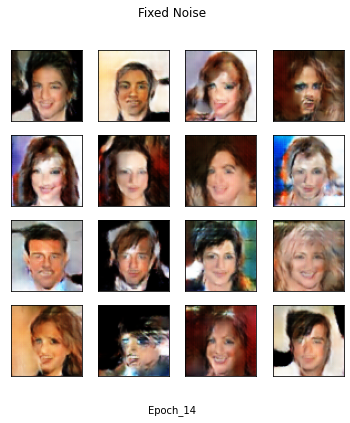

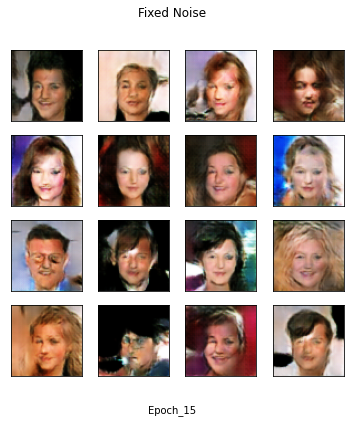

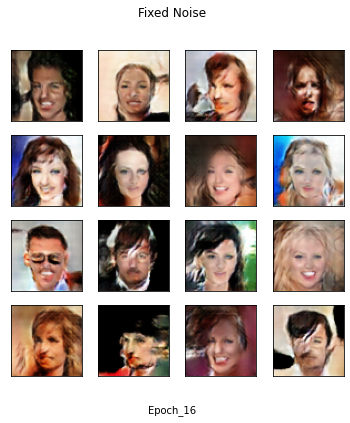

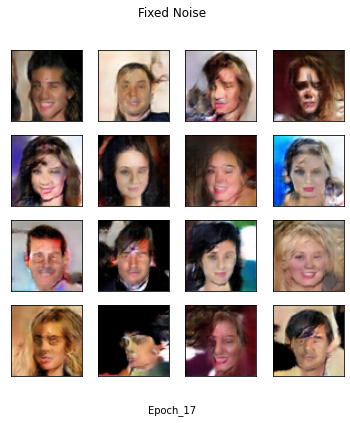

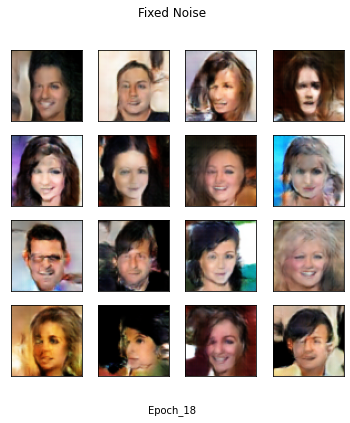

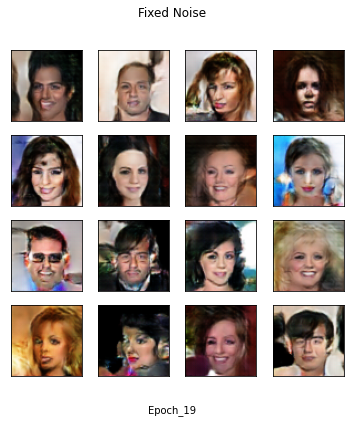

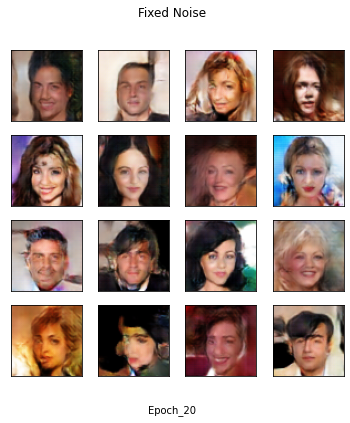

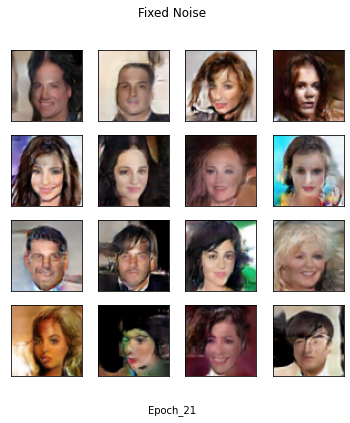

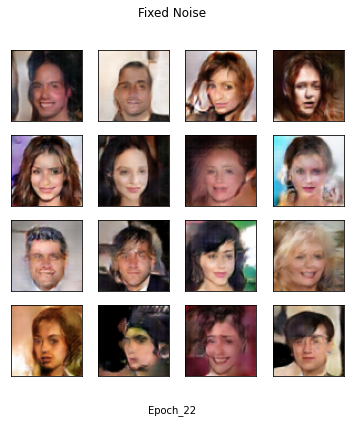

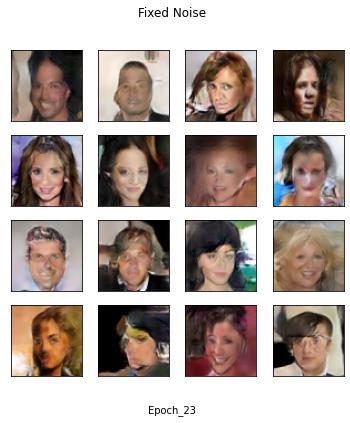

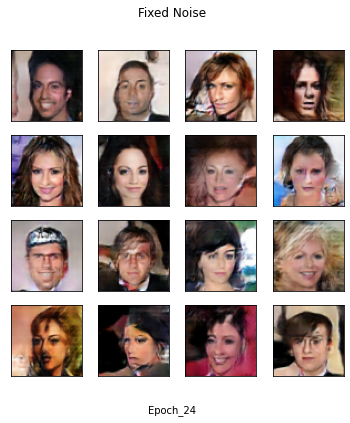

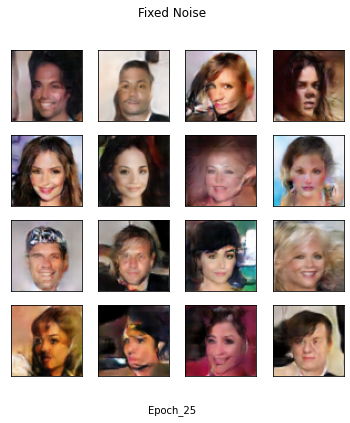

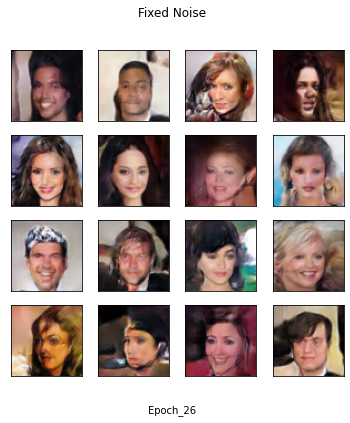

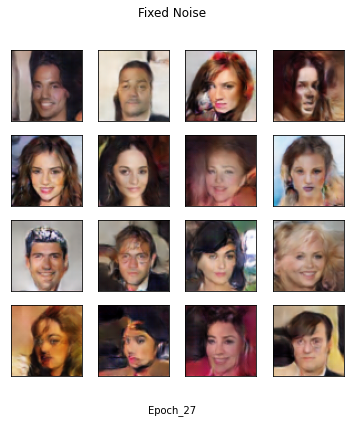

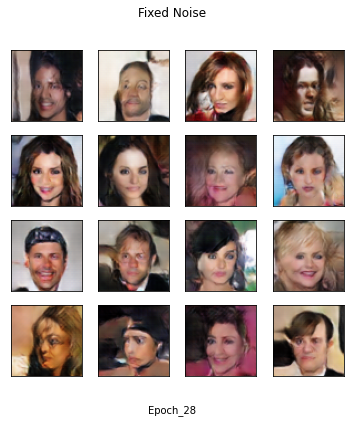

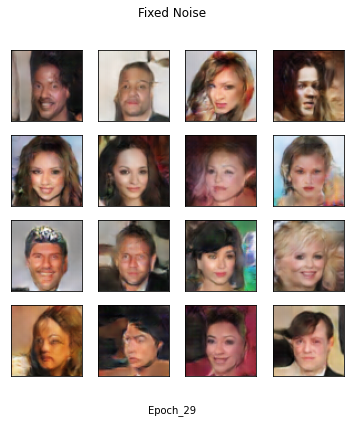

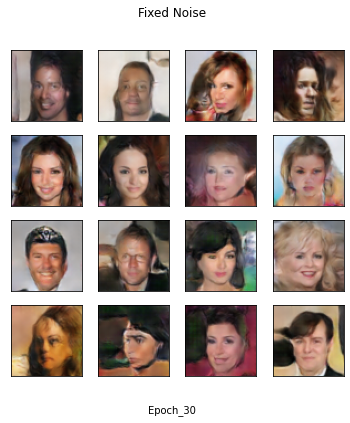

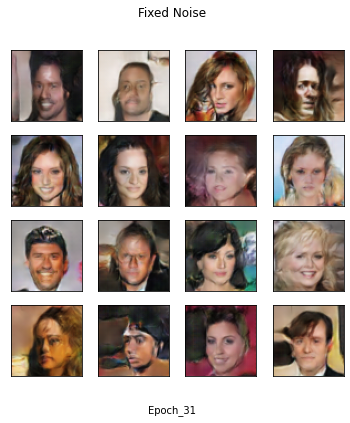

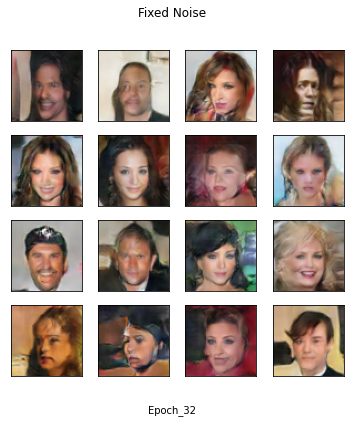

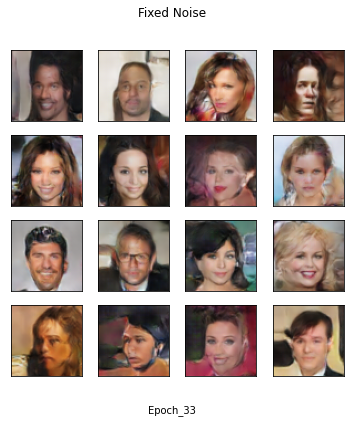

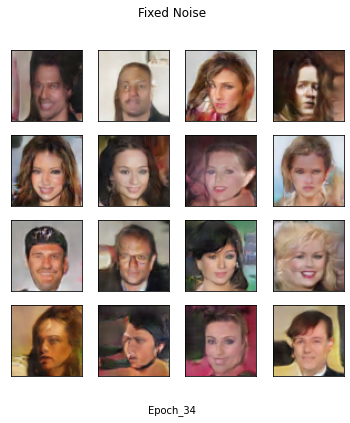

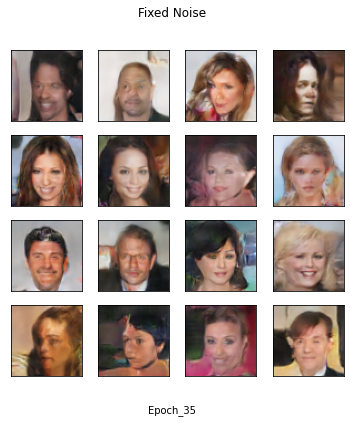

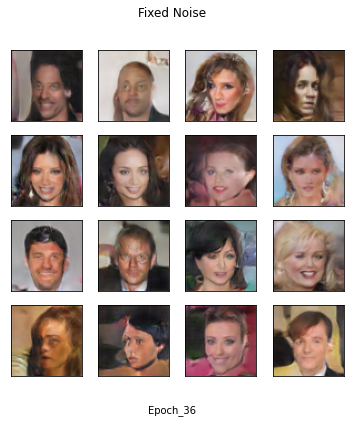

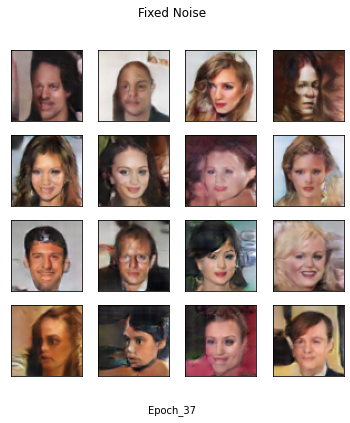

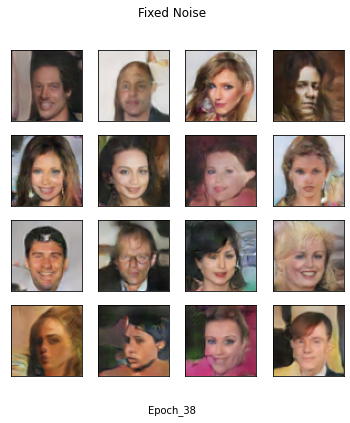

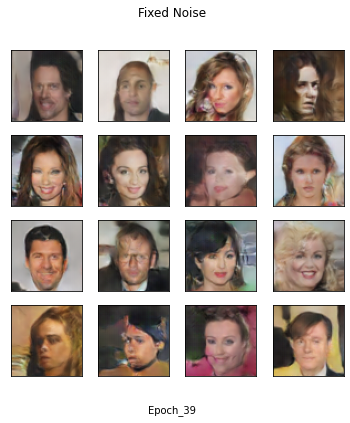

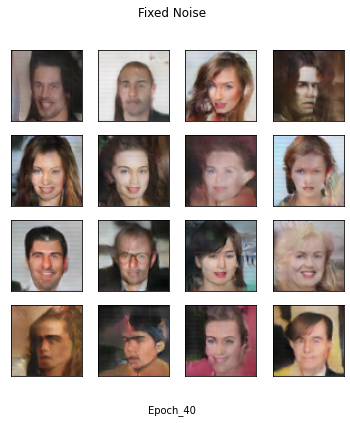

In [9]:
# Gather CelebA Dataset    
root = '../input/celeba-dataset/img_align_celeba/'
dataloader = get_data_loader(root, opt.batch_size)
print("Dataset loaded from " + root)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using", device)

# Define Discriminator and Generator architectures
netG = Generator(opt.nc, opt.nz, opt.ngf).to(device)
netD = Discriminator(opt.nc, opt.ndf).to(device)

# loss function
criterion = nn.BCELoss()

# optimizers
optimizerD = optim.Adam(netD.parameters(), lr=opt.d_lr)
optimizerG = optim.Adam(netG.parameters(), lr=opt.g_lr)

# initialize other variables
real_label = 1
fake_label = 0
num_batches = len(dataloader)
fixed_noise = torch.randn(opt.num_test_samples, 100, 1, 1, device=device)

for epoch in range(opt.num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        bs = real_images.shape[0]
        ##############################
        #   Training discriminator   #
        ##############################

        netD.zero_grad()
        real_images = real_images.to(device)
        label = torch.full((bs,), real_label, device=device)

        output = netD(real_images)
        lossD_real = criterion(output.to(torch.float32), label.to(torch.float32))
        lossD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(bs, opt.nz, 1, 1, device=device)
        fake_images = netG(noise)
        label.fill_(fake_label)
        output = netD(fake_images.detach())
        lossD_fake = criterion(output.to(torch.float32), label.to(torch.float32))
        lossD_fake.backward()
        D_G_z1 = output.mean().item()
        lossD = lossD_real + lossD_fake
        optimizerD.step()

        ##########################
        #   Training generator   #
        ##########################

        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake_images)
        lossG = criterion(output.to(torch.float32), label.to(torch.float32))
        lossG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if (i+1)%100 == 0:
            print('Epoch [{}/{}], step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, Discriminator - D(G(x)): {:.2f}, Generator - D(G(x)): {:.2f}'.format(epoch+1, opt.num_epochs, 
                                                        i+1, num_batches, lossD.item(), lossG.item(), D_x, D_G_z1, D_G_z2))
    netG.eval()
    generate_images(epoch, opt.output_path, fixed_noise, opt.num_test_samples, netG, device, use_fixed=opt.use_fixed)
    netG.train()

In [10]:
save_gif(opt.output_path, opt.fps, fixed_noise=opt.use_fixed)